# ** WALMART STORE SALES FORECASTING** **

In [1]:
'''Import necessary packages'''

from keras.models import Sequential
from keras.layers import Dense
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import median_absolute_error 
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
!pip install joblib
import joblib
!pip install xgboost
from xgboost import XGBRegressor
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


#  Reading data into the notebook

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [0]:
import io
train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
# Dataset is now stored in a Pandas Dataframe

In [4]:
print(train_df.shape)
train_df.head(3)

(421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [5]:
from google.colab import files
uploaded = files.upload()

Saving stores.csv to stores (1).csv


In [0]:
import io
stores_df = pd.read_csv(io.BytesIO(uploaded['stores.csv']))
# Dataset is now stored in a Pandas Dataframe

In [7]:
print(stores_df.shape)
stores_df.head(3)

(45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


In [0]:
train_df = train_df.merge(stores_df, how='left')

In [9]:
train_df.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315


In [10]:
from google.colab import files
uploaded = files.upload()

Saving features.csv to features (1).csv


In [0]:
import io
features_df = pd.read_csv(io.BytesIO(uploaded['features.csv']))
# Dataset is now stored in a Pandas Dataframe

In [12]:
print(features_df.shape)
features_df.head(3)

(8190, 12)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


In [0]:
train_df = train_df.merge(features_df, how='left')

In [14]:
train_df.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106


In [15]:
print(train_df.shape)

(421570, 16)


# **Sorting and Splitting data into Train-Validation dataset and Test dataset**

1. Sorting & train-test split

In [16]:
# Sorting data based on date
train_df.sort_values(by = ["Date"],inplace = True)
print(train_df.head(5))

        Store  Dept        Date  ...  MarkDown5         CPI Unemployment
0           1     1  2010-02-05  ...        NaN  211.096358        8.106
277665     29     5  2010-02-05  ...        NaN  131.527903       10.064
277808     29     6  2010-02-05  ...        NaN  131.527903       10.064
277951     29     7  2010-02-05  ...        NaN  131.527903       10.064
278094     29     8  2010-02-05  ...        NaN  131.527903       10.064

[5 rows x 16 columns]


In [0]:
'''Define functions to split data,'''

def split_df(df,num):
    return df[ :num].copy(),df[num: ].copy()

In [0]:
# Convert date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [19]:
df_train_valid,df_test = split_df(train_df,316177)

print(df_train_valid.shape,df_test.shape)

(316177, 16) (105393, 16)


# **TRAIN-VALIDATION DATASET**

# **1. Data Exploration**

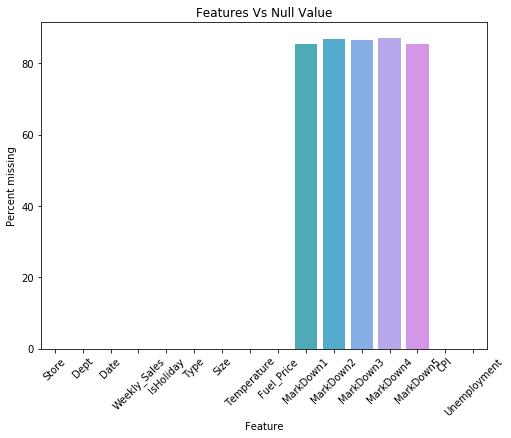

In [20]:
''' Deal with missing values. Calculating the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = df_train_valid.isnull().sum()/len(df_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
plt.title('Features Vs Null Value')
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [0]:
'''Dropping columns Markdown1-5 as 80% of data in these 5 columns are null '''
df_train_valid=df_train_valid.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"],axis = 1)

In [22]:
df_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316177 entries, 0 to 351531
Data columns (total 11 columns):
Store           316177 non-null int64
Dept            316177 non-null int64
Date            316177 non-null datetime64[ns]
Weekly_Sales    316177 non-null float64
IsHoliday       316177 non-null bool
Type            316177 non-null object
Size            316177 non-null int64
Temperature     316177 non-null float64
Fuel_Price      316177 non-null float64
CPI             316177 non-null float64
Unemployment    316177 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 26.8+ MB


In [0]:
def scatter(df_train_valid, column):
    plt.figure()
    plt.scatter(df_train_valid[column] , df_train_valid['Weekly_Sales'])
    plt.ylabel('weeklySales')
    plt.xlabel(column)

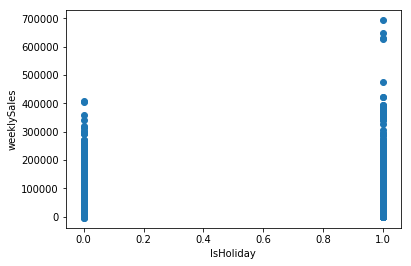

In [24]:
scatter(df_train_valid, 'IsHoliday')

In [25]:
'''From the graph, we can see that maximum sale occured on holiday '''

'From the graph, we can see that maximum sale occured on holiday '

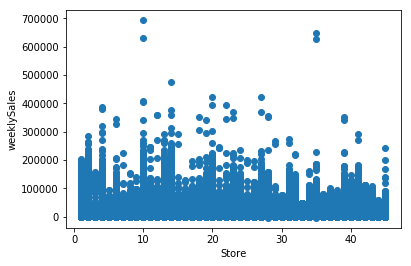

In [26]:
scatter(df_train_valid, 'Store')

In [27]:
'''From the graph, we can deduct that maximum sale occurs in store 10  '''

'From the graph, we can deduct that maximum sale occurs in store 10  '

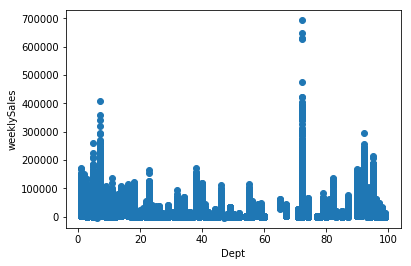

In [28]:
scatter(df_train_valid, 'Dept')

In [29]:
'''From the graph, we can deduct that maximum sale occurs in dept 72. Majority of the weekly sale is below 200000 '''

'From the graph, we can deduct that maximum sale occurs in dept 72. Majority of the weekly sale is below 200000 '

# **2. Confirming our observations**

In [30]:
'''Here we can see the maximum weekly_sale is 693099.360000. Also an interesting observation is 
that weekly_sale contains NEGATIVE VALUE which is not acceptable. So we need remove records with negative
weekly sale from our dataframe'''
df_train_valid["Weekly_Sales"].describe()

count    316177.000000
mean      16037.662343
std       22928.387599
min       -4988.940000
25%        2110.000000
50%        7652.950000
75%       20216.450000
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [31]:
max_weekly_sale = df_train_valid[df_train_valid["Weekly_Sales"] == 693099.360000]
max_weekly_sale

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
95373,10,72,2010-11-26,693099.36,True,B,126512,55.33,3.162,126.669267,9.003


# **3.Correlations between different variables in a dataframe:**

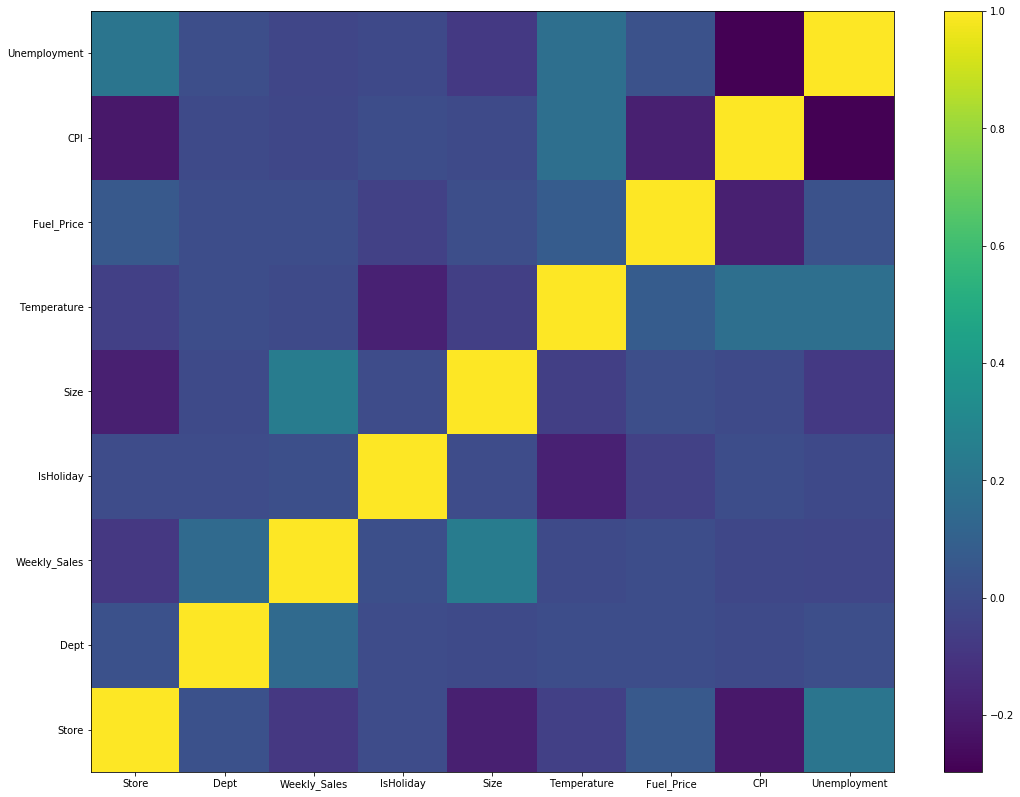

In [32]:
fig = plt.figure(figsize=(18, 14))
corr = df_train_valid.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

# **4.Drop records with negative weekly sale**

In [33]:
'''There are 937 records that contains weekly sale with negative value. Let us next check if there are any records 
with 0 weekly sale'''

neg_weekly_sale=df_train_valid[df_train_valid.Weekly_Sales < 0]
print (neg_weekly_sale.shape)

(937, 11)


In [34]:
'''We can see that there are 59 records with 0 weekly sale.'''
zero_weekly_sale = df_train_valid[df_train_valid["Weekly_Sales"] == 0]
print (zero_weekly_sale.shape)

(59, 11)


In [35]:
''' The negative weekly sale may be due to the misplaced negative sign while entering/inserting the weekly sale.
Since we cannot make assumptions, we are dropping these records '''
df_train_valid_1=df_train_valid[df_train_valid.Weekly_Sales >= 0]
print (df_train_valid_1.shape)

(315240, 11)


In [36]:
df_train_valid_1.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment
count,315240.000000,315240.000000,315240.000000,315240.000000,315240.000000,315240.000000,315240.000000,315240.000000
mean,22.176656,44.176367,16085.549899,136859.693675,57.642401,3.225525,169.842205,8.179939
std,12.782800,30.455451,22945.577760,60935.241436,19.084217,0.431991,38.599360,1.867125
min,1.000000,1.000000,0.000000,34875.000000,-2.060000,2.472000,126.064000,4.261000
25%,11.000000,18.000000,2147.567500,93638.000000,43.510000,2.826000,131.901968,7.197000
50%,22.000000,37.000000,7703.595000,140167.000000,58.460000,3.159000,182.120157,8.021000
75%,33.000000,72.000000,20276.955000,202505.000000,72.220000,3.600000,211.188693,8.625000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.211000,224.374138,14.313000


# **5.Splitting dates and processing data**

In [0]:
'''Define functions to preprocess data - split dates, categorize, impute'''

def split_dates(df,date_column):
    date_df = pd.DataFrame({"year": df[date_column].dt.year,
              "month": df[date_column].dt.month,
              "day": df[date_column].dt.day,
              "dayofyear": df[date_column].dt.dayofyear,
              "week": df[date_column].dt.week,
              "weekofyear": df[date_column].dt.weekofyear,
              "dayofweek": df[date_column].dt.dayofweek,
              "weekday": df[date_column].dt.weekday,
              "quarter": df[date_column].dt.quarter,
             })
    df = df.drop(date_column,axis = 1)
    df = pd.concat([df,date_df],axis = 1)
    return df

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [38]:
# Splitting dates
df_train_valid_2 = split_dates(df_train_valid_1,"Date")
print(df_train_valid_2.shape)

(315240, 19)


In [39]:
df_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315240 entries, 0 to 351531
Data columns (total 19 columns):
Store           315240 non-null int64
Dept            315240 non-null int64
Weekly_Sales    315240 non-null float64
IsHoliday       315240 non-null bool
Type            315240 non-null object
Size            315240 non-null int64
Temperature     315240 non-null float64
Fuel_Price      315240 non-null float64
CPI             315240 non-null float64
Unemployment    315240 non-null float64
year            315240 non-null int64
month           315240 non-null int64
day             315240 non-null int64
dayofyear       315240 non-null int64
week            315240 non-null int64
weekofyear      315240 non-null int64
dayofweek       315240 non-null int64
weekday         315240 non-null int64
quarter         315240 non-null int64
dtypes: bool(1), float64(5), int64(12), object(1)
memory usage: 46.0+ MB


In [40]:
# Converting string to category
df_train_valid_3 = str_to_cat(df_train_valid_2)
print(df_train_valid_3.shape)
df_train_valid_3.head(3)

(315240, 19)


,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,1,1,24924.50,False,A,151315,42.31,2.572,211.096358,8.106,2010,2,5,36,5,5,4,4,1
277665,29,5,15552.08,False,B,93638,24.36,2.788,131.527903,10.064,2010,2,5,36,5,5,4,4,1
277808,29,6,3200.22,False,B,93638,24.36,2.788,131.527903,10.064,2010,2,5,36,5,5,4,4,1


In [41]:
df_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315240 entries, 0 to 351531
Data columns (total 19 columns):
Store           315240 non-null int64
Dept            315240 non-null int64
Weekly_Sales    315240 non-null float64
IsHoliday       315240 non-null bool
Type            315240 non-null category
Size            315240 non-null int64
Temperature     315240 non-null float64
Fuel_Price      315240 non-null float64
CPI             315240 non-null float64
Unemployment    315240 non-null float64
year            315240 non-null int64
month           315240 non-null int64
day             315240 non-null int64
dayofyear       315240 non-null int64
week            315240 non-null int64
weekofyear      315240 non-null int64
dayofweek       315240 non-null int64
weekday         315240 non-null int64
quarter         315240 non-null int64
dtypes: bool(1), category(1), float64(5), int64(12)
memory usage: 43.9 MB


In [42]:
# Imputing null values. The output from the above line of code indicates that there are no null values in the train dataframe.
train_processed,my_table = mydf_preprocessor(df_train_valid_3,null_table = None)
print(train_processed.shape)
train_processed.head(3)

(315240, 19)


,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,1,1,24924.50,False,1,151315,42.31,2.572,211.096358,8.106,2010,2,5,36,5,5,4,4,1
277665,29,5,15552.08,False,2,93638,24.36,2.788,131.527903,10.064,2010,2,5,36,5,5,4,4,1
277808,29,6,3200.22,False,2,93638,24.36,2.788,131.527903,10.064,2010,2,5,36,5,5,4,4,1


In [43]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315240 entries, 0 to 351531
Data columns (total 19 columns):
Store           315240 non-null int64
Dept            315240 non-null int64
Weekly_Sales    315240 non-null float64
IsHoliday       315240 non-null bool
Type            315240 non-null int8
Size            315240 non-null int64
Temperature     315240 non-null float64
Fuel_Price      315240 non-null float64
CPI             315240 non-null float64
Unemployment    315240 non-null float64
year            315240 non-null int64
month           315240 non-null int64
day             315240 non-null int64
dayofyear       315240 non-null int64
week            315240 non-null int64
weekofyear      315240 non-null int64
dayofweek       315240 non-null int64
weekday         315240 non-null int64
quarter         315240 non-null int64
dtypes: bool(1), float64(5), int64(12), int8(1)
memory usage: 43.9 MB


In [44]:
my_table

{}

In [45]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315240 entries, 0 to 351531
Data columns (total 19 columns):
Store           315240 non-null int64
Dept            315240 non-null int64
Weekly_Sales    315240 non-null float64
IsHoliday       315240 non-null bool
Type            315240 non-null int8
Size            315240 non-null int64
Temperature     315240 non-null float64
Fuel_Price      315240 non-null float64
CPI             315240 non-null float64
Unemployment    315240 non-null float64
year            315240 non-null int64
month           315240 non-null int64
day             315240 non-null int64
dayofyear       315240 non-null int64
week            315240 non-null int64
weekofyear      315240 non-null int64
dayofweek       315240 non-null int64
weekday         315240 non-null int64
quarter         315240 non-null int64
dtypes: bool(1), float64(5), int64(12), int8(1)
memory usage: 43.9 MB


**Creating new column based on weight**

In [0]:
''' Creating new column "IsHoliday_weight" based on weight assigned on column "IsHoliday".
If the value in IsHoliday column is true, assign 5 else assign 1'''
train_processed['IsHoliday_weight']=train_processed['IsHoliday'].replace(True, 5).replace(False, 1)

In [0]:
'''Converting to int datatype'''
train_processed.IsHoliday_weight = train_processed.IsHoliday_weight.astype(int)

In [48]:
train_processed.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,IsHoliday_weight
0,1,1,24924.50,False,1,151315,42.31,2.572,211.096358,8.106,2010,2,5,36,5,5,4,4,1,1
277665,29,5,15552.08,False,2,93638,24.36,2.788,131.527903,10.064,2010,2,5,36,5,5,4,4,1,1
277808,29,6,3200.22,False,2,93638,24.36,2.788,131.527903,10.064,2010,2,5,36,5,5,4,4,1,1
277951,29,7,10820.05,False,2,93638,24.36,2.788,131.527903,10.064,2010,2,5,36,5,5,4,4,1,1
278094,29,8,20055.64,False,2,93638,24.36,2.788,131.527903,10.064,2010,2,5,36,5,5,4,4,1,1


In [0]:
'''Separating target variable and input variable'''
Y = train_processed["Weekly_Sales"]
X = train_processed.drop(["Weekly_Sales"],axis = 1)

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315240 entries, 0 to 351531
Data columns (total 19 columns):
Store               315240 non-null int64
Dept                315240 non-null int64
IsHoliday           315240 non-null bool
Type                315240 non-null int8
Size                315240 non-null int64
Temperature         315240 non-null float64
Fuel_Price          315240 non-null float64
CPI                 315240 non-null float64
Unemployment        315240 non-null float64
year                315240 non-null int64
month               315240 non-null int64
day                 315240 non-null int64
dayofyear           315240 non-null int64
week                315240 non-null int64
weekofyear          315240 non-null int64
dayofweek           315240 non-null int64
weekday             315240 non-null int64
quarter             315240 non-null int64
IsHoliday_weight    315240 non-null int64
dtypes: bool(1), float64(4), int64(13), int8(1)
memory usage: 43.9 MB


**Data Scaling**

In [51]:
'''Splitting continuous and categorical columns'''
X_con = X[['Size','Temperature','Fuel_Price','CPI','Unemployment']]
X_cat = X.drop(X_con,axis = 1)
print(X_cat.shape,X_con.shape)

(315240, 14) (315240, 5)


In [52]:
'''Scaling data'''
scaler = preprocessing.StandardScaler().fit(X_con)
X_scaled = pd.DataFrame(scaler.transform(X_con))
X_scaled.columns = ["Size","Temperature","Fuel_Price","CPI","Unemployment"]
X_scaled.head(2)


,Size,Temperature,Fuel_Price,CPI,Unemployment
0,0.237224,-0.803409,-1.512824,1.068780,-0.039600
1,-0.709306,-1.743978,-1.012812,-0.992617,1.009073


In [53]:
#Re-index before merging
X_cat.reset_index(inplace = True,drop = False)
X_cat.head()

,index,Store,Dept,IsHoliday,Type,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,IsHoliday_weight
0,0,1,1,False,1,2010,2,5,36,5,5,4,4,1,1
1,277665,29,5,False,2,2010,2,5,36,5,5,4,4,1,1
2,277808,29,6,False,2,2010,2,5,36,5,5,4,4,1,1
3,277951,29,7,False,2,2010,2,5,36,5,5,4,4,1,1
4,278094,29,8,False,2,2010,2,5,36,5,5,4,4,1,1


In [54]:
X_cat.drop("index",inplace = True,axis = 1)
X_cat.head(2)

,Store,Dept,IsHoliday,Type,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,IsHoliday_weight
0,1,1,False,1,2010,2,5,36,5,5,4,4,1,1
1,29,5,False,2,2010,2,5,36,5,5,4,4,1,1


In [55]:
df_list = [X_cat,X_scaled]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(315240, 19)


,Store,Dept,IsHoliday,Type,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,IsHoliday_weight,Size,Temperature,Fuel_Price,CPI,Unemployment
0,1,1,False,1,2010,2,5,36,5,5,4,4,1,1,0.237224,-0.803409,-1.512824,1.068780,-0.039600
1,29,5,False,2,2010,2,5,36,5,5,4,4,1,1,-0.709306,-1.743978,-1.012812,-0.992617,1.009073


In [57]:
'''Split into train and valid sets for model building 
and hyperparameter tuning, respectively'''

x_train,x_valid = split_df(X_full,268750)
Y_train,Y_valid = split_df(Y,268750)

print(x_train.shape,x_valid.shape,Y_train.shape,Y_valid.shape)

(268750, 19) (46490, 19) (268750,) (46490,)


In [0]:
'''Dropping the column IsHoliday and IsHoliday_weight '''

X_train=x_train.drop(["IsHoliday","IsHoliday_weight"],axis = 1)
X_valid=x_valid.drop(["IsHoliday","IsHoliday_weight"],axis = 1)

In [59]:
'''Calculating sum of weights in IsHoliday_weight column in train dataset'''
sum_result_train = x_train.sum(axis = 0, skipna = True) 
sum_result_train.IsHoliday_weight

339194.0

In [60]:
'''Calculating sum of weights in IsHoliday_weight column in validation dataset'''
sum_result_valid = x_valid.sum(axis = 0, skipna = True) 
sum_result_valid.IsHoliday_weight

82470.0

# **TEST DATASET**

# **1.Exploring Test data**

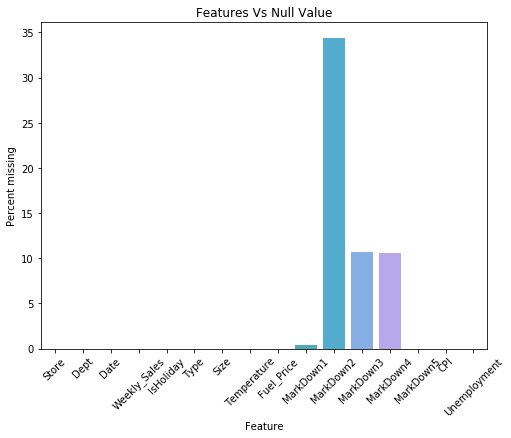

In [61]:
''' Deal with missing values. Calculating the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = df_test.isnull().sum()/len(df_test)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
plt.title('Features Vs Null Value')
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [0]:
'''Dropping column'''
df_test=df_test.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"],axis = 1)

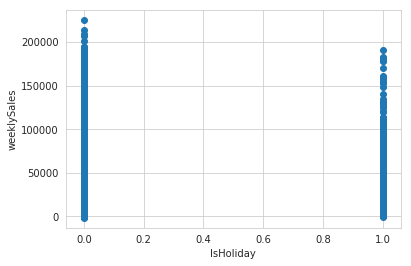

In [201]:
scatter(df_test, 'IsHoliday')

In [202]:
'''From the graph, we can see that maximum sale occured on non  holiday. 
This graph is disimilar from train dataset. '''

'From the graph, we can see that maximum sale occured on non  holiday. \nThis graph is disimilar from train dataset. '

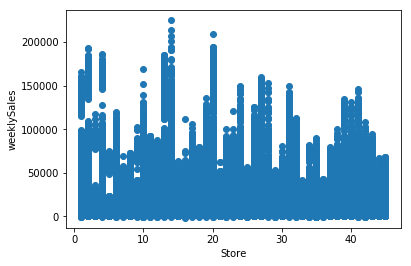

In [65]:
scatter(df_test, 'Store')

In [203]:
'''From the graph, we can deduct that maximum sale occured in store 14 which is same as the train data.
And the majority of weekly sale is below 200000'''

'From the graph, we can deduct that maximum sale occured in store 14 which is same as the train data.\nAnd the majority of weekly sale is below 200000'

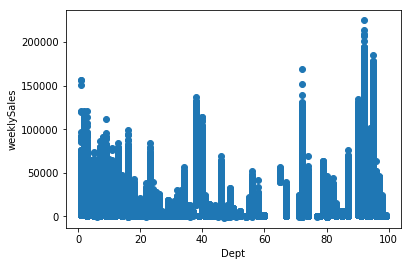

In [67]:
scatter(df_test, 'Dept')

In [204]:
'''From the graph, we can deduct that maximum sale occurs in dept 92 which is same as train dataset. '''

'From the graph, we can deduct that maximum sale occurs in dept 92 which is same as train dataset. '

# **2.Confirming our observations**

In [69]:
'''Here we can see the maximum weekly_sale is 224917.940000. Also an interesting observation is 
that weekly_sale contains NEGATIVE VALUE which is not acceptable. So we need remove records with negative
weekly sale from our dataframe'''
df_test["Weekly_Sales"].describe()

count    105393.000000
mean      15812.046536
std       22045.980827
min       -1699.000000
25%        1987.780000
50%        7494.340000
75%       20174.360000
max      224917.940000
Name: Weekly_Sales, dtype: float64

In [70]:
max_weekly_sale_test = df_test[df_test["Weekly_Sales"] == 224917.940000]
max_weekly_sale_test

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
137319,14,92,2012-04-06,224917.94,False,A,200898,49.73,3.996,190.685171,8.567


# **3.Correlations between different variables in a dataframe:**

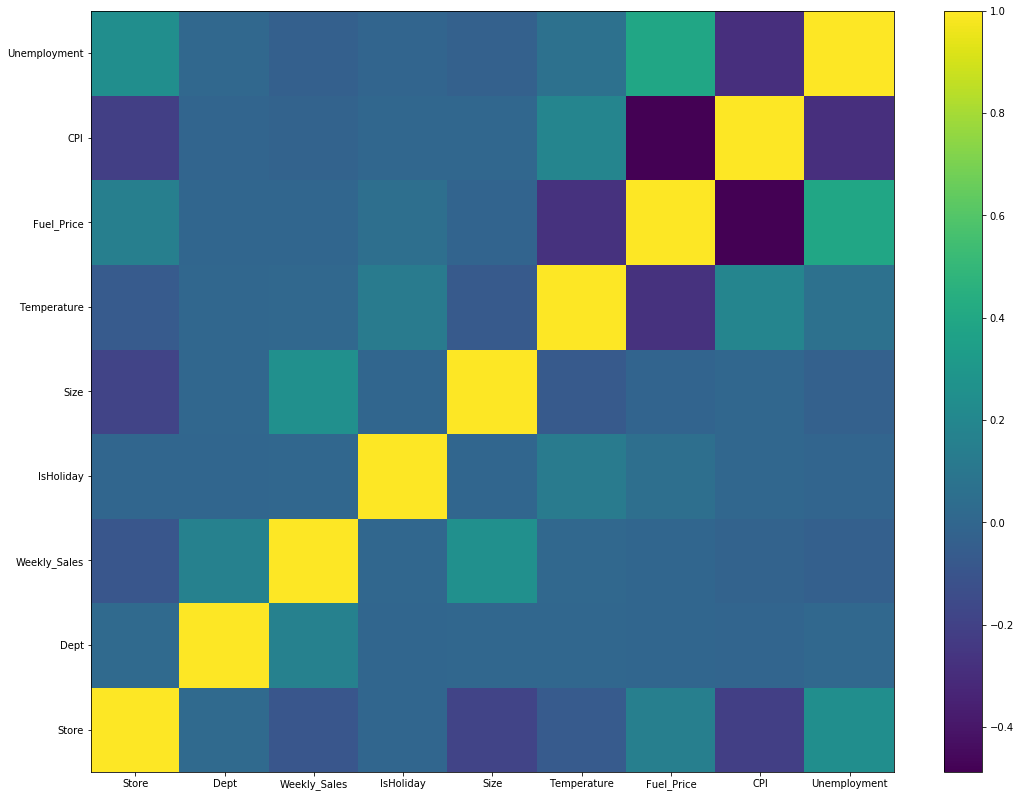

In [71]:
'''The correlation between variables in test dataset is similar to train dataset'''
fig = plt.figure(figsize=(18, 14))
corr = df_test.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

# **4.Drop records with negative weekly sale from Test data**

In [72]:
'''There are 348 records that contains weekly sale with negative value. Let us next check if there are any records 
with 0 weekly sale'''

neg_weekly_sale_test=df_test[df_test.Weekly_Sales < 0]
print (neg_weekly_sale_test.shape)

(348, 11)


In [73]:
'''We can see that there are 14 records with 0 weekly sale.'''
zero_weekly_sale_test = df_test[df_test["Weekly_Sales"] == 0]
print (zero_weekly_sale_test.shape)

(14, 11)


In [74]:
''' The negative weekly sale may be due to the misplaced negative sign while entering/inserting the weekly sale.
Since we cannot make assumptions, we are dropping these records '''
df_test_1=df_test[df_test.Weekly_Sales >= 0]
print (df_test_1.shape)

(105045, 11)


In [75]:
df_test_1.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment
count,105045.000000,105045.000000,105045.000000,105045.000000,105045.000000,105045.000000,105045.000000,105045.000000
mean,22.251959,44.442049,15864.614198,136419.085601,67.437142,3.767113,175.323361,7.300272
std,12.800344,30.661242,22063.509815,61163.863702,14.026784,0.247268,40.528132,1.690337
min,1.000000,1.000000,0.000000,34875.000000,21.640000,3.129000,130.550207,3.879000
25%,11.000000,18.000000,2030.000000,93638.000000,58.200000,3.603000,137.584387,6.170000
50%,22.000000,37.000000,7543.490000,140167.000000,69.110000,3.759000,190.610746,7.143000
75%,33.000000,74.000000,20242.490000,202505.000000,78.110000,3.927000,220.924486,8.253000
max,45.000000,99.000000,224917.940000,219622.000000,100.070000,4.468000,227.232807,12.187000


# **5.Splitting dates and processing Test data**

In [76]:
# Splitting dates
df_test_2 = split_dates(df_test_1,"Date")
print(df_test_2.shape)

(105045, 19)


In [77]:
# Converting string to category
df_test_3 = str_to_cat(df_test_2)
print(df_test_3.shape)
df_test_3.head(3)

(105045, 19)


,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
379899,40,91,45375.31,False,A,155083,29.88,3.751,137.341103,4.261,2012,2,24,55,8,8,4,4,1
123518,13,45,35.88,False,A,219622,35.38,3.145,130.550207,6.104,2012,2,24,55,8,8,4,4,1
47671,5,85,649.08,False,B,34875,57.75,3.555,221.222424,5.943,2012,2,24,55,8,8,4,4,1


In [78]:
#Imputing null values based on entry in my_table.(my_table is null as  there were no null values in train dataset )
test_processed,my_table = mydf_preprocessor(df_test_3,null_table = my_table)
print(test_processed.shape)
test_processed.head(3)

(105045, 19)


,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
379899,40,91,45375.31,False,1,155083,29.88,3.751,137.341103,4.261,2012,2,24,55,8,8,4,4,1
123518,13,45,35.88,False,1,219622,35.38,3.145,130.550207,6.104,2012,2,24,55,8,8,4,4,1
47671,5,85,649.08,False,2,34875,57.75,3.555,221.222424,5.943,2012,2,24,55,8,8,4,4,1


In [79]:
test_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105045 entries, 379899 to 421569
Data columns (total 19 columns):
Store           105045 non-null int64
Dept            105045 non-null int64
Weekly_Sales    105045 non-null float64
IsHoliday       105045 non-null bool
Type            105045 non-null int8
Size            105045 non-null int64
Temperature     105045 non-null float64
Fuel_Price      105045 non-null float64
CPI             105045 non-null float64
Unemployment    105045 non-null float64
year            105045 non-null int64
month           105045 non-null int64
day             105045 non-null int64
dayofyear       105045 non-null int64
week            105045 non-null int64
weekofyear      105045 non-null int64
dayofweek       105045 non-null int64
weekday         105045 non-null int64
quarter         105045 non-null int64
dtypes: bool(1), float64(5), int64(12), int8(1)
memory usage: 14.6 MB


**Creating new column based on weight**

In [0]:
''' Creating new column "IsHoliday_weight" based on weight assigned on column "IsHoliday".
If the value in IsHoliday column is true, assign 5 else assign 1'''
test_processed['IsHoliday_weight']=test_processed['IsHoliday'].replace(True, 5).replace(False, 1)

In [0]:
'''Converting to int datatype'''
test_processed.IsHoliday_weight = test_processed.IsHoliday_weight.astype(int)

In [82]:
test_processed.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,IsHoliday_weight
379899,40,91,45375.31,False,1,155083,29.88,3.751,137.341103,4.261,2012,2,24,55,8,8,4,4,1,1
123518,13,45,35.88,False,1,219622,35.38,3.145,130.550207,6.104,2012,2,24,55,8,8,4,4,1,1
47671,5,85,649.08,False,2,34875,57.75,3.555,221.222424,5.943,2012,2,24,55,8,8,4,4,1,1
274145,28,60,612.00,False,1,206302,53.13,3.950,130.550207,12.187,2012,2,24,55,8,8,4,4,1,1
159001,17,11,12391.91,False,2,93188,30.01,3.145,130.550207,6.403,2012,2,24,55,8,8,4,4,1,1


In [0]:
Y_test = test_processed["Weekly_Sales"]
x_test = test_processed.drop(["Weekly_Sales"],axis = 1)

**Data Scaling**

In [84]:
'''Splitting test data into categorical and continuous dataset'''
X_con_test = x_test[['Size','Temperature','Fuel_Price','CPI','Unemployment']]
X_cat_test = x_test.drop(X_con_test,axis = 1)
print(X_cat_test.shape,X_con_test.shape)

(105045, 14) (105045, 5)


In [85]:
'''Scale using the training set mean and SD. This is already captured in
the scaler object we made. '''

X_con_sct = pd.DataFrame(scaler.transform(X_con_test))
X_con_sct.columns = ["Size","Temperature","Fuel_Price","CPI","Unemployment"]
print(X_con_sct.shape)
X_con_sct.head(2)



(105045, 5)


,Size,Temperature,Fuel_Price,CPI,Unemployment
0,0.299061,-1.454733,1.216405,-0.842013,-2.098920
1,1.358203,-1.166537,-0.186405,-1.017946,-1.111839


In [86]:
print(X_cat_test.shape,X_con_sct.shape)

(105045, 14) (105045, 5)


In [87]:
#Re-index before merging
X_cat_test.reset_index(inplace = True,drop = False)
X_cat_test.head()

,index,Store,Dept,IsHoliday,Type,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,IsHoliday_weight
0,379899,40,91,False,1,2012,2,24,55,8,8,4,4,1,1
1,123518,13,45,False,1,2012,2,24,55,8,8,4,4,1,1
2,47671,5,85,False,2,2012,2,24,55,8,8,4,4,1,1
3,274145,28,60,False,1,2012,2,24,55,8,8,4,4,1,1
4,159001,17,11,False,2,2012,2,24,55,8,8,4,4,1,1


In [88]:
X_cat_test.drop("index",inplace = True,axis = 1)
X_cat_test.head(2)

,Store,Dept,IsHoliday,Type,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,IsHoliday_weight
0,40,91,False,1,2012,2,24,55,8,8,4,4,1,1
1,13,45,False,1,2012,2,24,55,8,8,4,4,1,1


In [89]:
#Merge the two sets of columns
df_list_I = [X_cat_test,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(2)

(105045, 19)


,Store,Dept,IsHoliday,Type,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,IsHoliday_weight,Size,Temperature,Fuel_Price,CPI,Unemployment
0,40,91,False,1,2012,2,24,55,8,8,4,4,1,1,0.299061,-1.454733,1.216405,-0.842013,-2.098920
1,13,45,False,1,2012,2,24,55,8,8,4,4,1,1,1.358203,-1.166537,-0.186405,-1.017946,-1.111839


In [0]:
'''Dropping the column IsHoliday and IsHoliday_weight '''

X_test=X_test_I.drop(["IsHoliday","IsHoliday_weight"],axis = 1)

In [91]:
X_test.isnull().sum()


Store           0
Dept            0
Type            0
year            0
month           0
day             0
dayofyear       0
week            0
weekofyear      0
dayofweek       0
weekday         0
quarter         0
Size            0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [92]:
'''Calculating sum of weights in IsHoliday_weight column in test dataset'''
sum_result_test = X_test_I.sum(axis = 0, skipna = True) 
sum_result_test.IsHoliday_weight

116873.0

In [0]:
# for storing models and error results
model_list_wmae = list()
wmae_list = list()

# **Evaluation metrics: WEIGHTED MEAN ABSOLUTE ERROR**



In [0]:
def my_wmae(y1,y2,w1,w2):
    return (((y1-y2).abs()*w1).sum())/w2

def weighted_mean_absolute_error(my_model,x_data,y_data,IsHoliday_data,sum_of_IsHoliday):
    result = [my_wmae(my_model.predict(x_data),y_data,IsHoliday_data,sum_of_IsHoliday)]
    return "weighted_mean_absolute_error", result

**Functions**

In [0]:
'''This function extracts string from tuple and removes '[',']' from the string '''
def string_process(my_string):
  s=str(my_string)
  s1 = s.replace('[','')
  s2= s1.replace(']','')
  return s2

In [0]:
'''This function converts string to float'''
def string_to_float(my_string):
  str_lst = [my_string]
  float_lst = [float(n) for n in str_lst]
  return float_lst

# **Build and Train a k-NN Regression model**

In [97]:
my_knn_model = KNeighborsRegressor(n_neighbors = 10,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)



KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [98]:
my_knn_model.score(X_valid, Y_valid)

0.500736286229073

**Hyperparameter tuning**

In [0]:
from sklearn.metrics import accuracy_score

num_neighs = list()
accuracy_list = list()


for neighbor in range(1,20):
    my_knn_model = KNeighborsRegressor(n_neighbors = neighbor,weights = 'uniform')
    my_knn_model.fit(X_train,Y_train)
    #Y_pred = my_knn_model.predict(X_valid)
    accuracy = my_knn_model.score(X_valid,Y_valid)
    num_neighs.append(neighbor)
    accuracy_list.append(accuracy)

In [100]:
eval_df =  pd.DataFrame({"Num of neighbors": num_neighs,"Valid accuracy Score": accuracy_list})
eval_df

,Num of neighbors,Valid accuracy Score
0,1,0.949922
1,2,0.617758
2,3,0.593028
3,4,0.591305
4,5,0.566446
5,6,0.559897
6,7,0.539338
7,8,0.523438
8,9,0.513313
9,10,0.500736


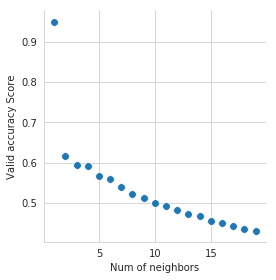

In [101]:
#Plot accuracy Vs validation set accuracy of the model
sns.set_style("whitegrid")
sns.pairplot(eval_df,x_vars = "Num of neighbors",
             y_vars = "Valid accuracy Score",plot_kws = {'s': 60},height = 4.0)

In [102]:
''' K = 2 '''


knn_model_fin = KNeighborsRegressor(n_neighbors = 2,weights = 'uniform')
knn_model_fin.fit(X_train,Y_train)



KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [0]:
#Predict on the validation set
Y_pred_kNN = knn_model_fin.predict(X_valid)

In [104]:
knn_model_fin.score(X_valid, Y_valid)

0.6177580367000058

In [105]:
'''Calculate WMAE for the validation dataset'''
WMAE_valid_kNN=weighted_mean_absolute_error(knn_model_fin,X_valid,Y_valid,x_valid.IsHoliday_weight,sum_result_valid.IsHoliday_weight)
WMAE_valid_kNN

('weighted_mean_absolute_error', [780.0845128531588])

**Validating on test data**

In [0]:
#Testing...
Y_test_pred_kNN = knn_model_fin.predict(X_test)

In [107]:
knn_model_fin.score(X_test, Y_test)

0.6907885502381697

In [108]:
'''Calculate WMAE for the test dataset'''
WMAE_test_kNN=weighted_mean_absolute_error(knn_model_fin,X_test,Y_test,x_test.IsHoliday_weight,sum_result_test.IsHoliday_weight)
WMAE_test_kNN

('weighted_mean_absolute_error', [7432.05531350269])

In [0]:
w_test_kNN=string_process(WMAE_test_kNN[1])

In [0]:
w_valid_kNN=string_process(WMAE_valid_kNN[1])

In [0]:
wmae_test_kNN = string_to_float(w_test_kNN)

In [0]:
wmae_valid_kNN = string_to_float(w_valid_kNN)

In [0]:
model="KNeighborsRegressor"
model_list_wmae.append(model)
wmae_list.append(wmae_test_kNN[0])

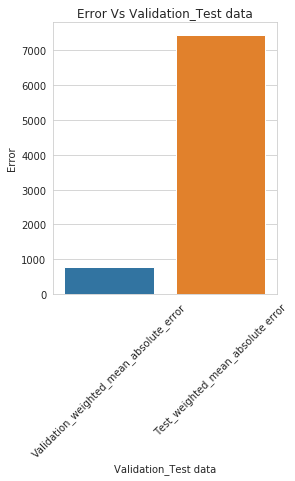

In [114]:
'''Visualizing validation and test weighted mean absolute error '''

plt.figure(figsize = (4,5))
plt.xticks(rotation=45)
plt.title('Error Vs Validation_Test data')
plt.ylabel('Error')
plt.xlabel('Validation_Test data')
x_number_list = [ "Validation_weighted_mean_absolute_error", "Test_weighted_mean_absolute error"]
y_number_list = [wmae_valid_kNN[0], wmae_test_kNN[0]]
sns.barplot(x = x_number_list,y = y_number_list)

# **Build and Train a Deep Neural Network**

In [0]:
# Function to create model, required for KerasRegressor
def create_model():
    model = Sequential()
    model.add(Dense(35, input_dim=17, init='normal', activation='relu'))
    model.add(Dense(40, init='normal', activation='relu'))
    model.add(Dense(25, init='normal', activation='relu'))
    model.add(Dense(15, init='normal', activation='relu'))
    model.add(Dense(5, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
    return model

**Hyperparameter Tuning**

In [0]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [0]:
# create model
estimator_model = KerasRegressor(build_fn=create_model,nb_epoch=2, batch_size=50000, verbose=0 )

In [0]:
# define the grid search parameters
batch_size = [10000,1000]
epochs = [1,5,25]

In [0]:
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=estimator_model, param_grid=param_grid, n_jobs=-1)

In [120]:
grid_result = grid.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
W0813 02:08:26.594652 140530763659136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(35, input_dim=17, activation="relu", kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0813 02:08:26.614287 140530763659136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder 

In [121]:
'''The scores are negative MSE scores, i.e. negate them and you get the MSE. The thing is that GridSearchCV,
by convention, always tries to maximize its score so loss functions like MSE have to be negated.'''
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -12220.105597 using {'batch_size': 1000, 'epochs': 25}
-15916.577720 (180.795008) with: {'batch_size': 10000, 'epochs': 1}
-15358.760444 (238.916845) with: {'batch_size': 10000, 'epochs': 5}
-13256.572796 (145.953600) with: {'batch_size': 10000, 'epochs': 25}
-14118.433089 (1094.669802) with: {'batch_size': 1000, 'epochs': 1}
-14115.174228 (1096.395246) with: {'batch_size': 1000, 'epochs': 5}
-12220.105597 (969.953330) with: {'batch_size': 1000, 'epochs': 25}


In [122]:
# Fit the DNN with your train data and evaluate on validation data

history = estimator_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), nb_epoch=25, batch_size=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(35, input_dim=17, activation="relu", kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(40, activation="relu", kernel_initializer="normal")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(25, activation="relu", kernel_initializer="normal")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, activation="relu", kernel_initializer="normal")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dens

In [0]:
y_pred_valid = estimator_model.predict(X_valid)

In [124]:
'''Calculate WMAE for the validation dataset'''
WMAE_valid_DNN=weighted_mean_absolute_error(estimator_model,X_valid,Y_valid,x_valid.IsHoliday_weight,sum_result_valid.IsHoliday_weight)
WMAE_valid_DNN

('weighted_mean_absolute_error', [1271.3627529770606])

**Epoch vs train-validation accuracy**

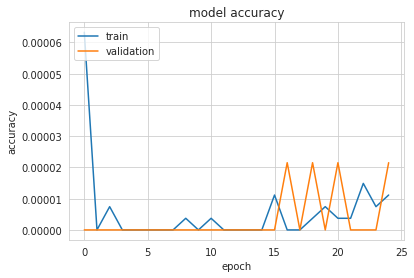

In [125]:
#accuracy vs epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Epoch vs train-validation loss**

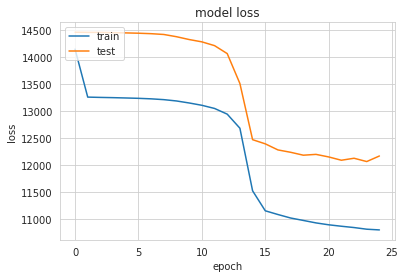

In [126]:
# epoch vs loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Validating on test data**

In [127]:
# Fit the DNN with your test data

history1 = estimator_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), nb_epoch=25, batch_size=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(35, input_dim=17, activation="relu", kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(40, activation="relu", kernel_initializer="normal")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(25, activation="relu", kernel_initializer="normal")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, activation="relu", kernel_initializer="normal")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dens

In [0]:
y_pred_test=estimator_model.predict(X_test)

In [129]:
'''Calculate WMAE for the test dataset'''
WMAE_test_DNN=weighted_mean_absolute_error(estimator_model,X_test,Y_test,x_test.IsHoliday_weight,sum_result_test.IsHoliday_weight)
WMAE_test_DNN

('weighted_mean_absolute_error', [10959.056109885467])

In [0]:
w_test_DNN=string_process(WMAE_test_DNN[1])

In [0]:
w_valid_DNN=string_process(WMAE_valid_DNN[1])

In [0]:
wmae_test_DNN = string_to_float(w_test_DNN)

In [0]:
wmae_valid_DNN = string_to_float(w_valid_DNN)

In [0]:
model = "Deep Neural Network"
model_list_wmae.append(model)
wmae_list.append(wmae_test_DNN[0])

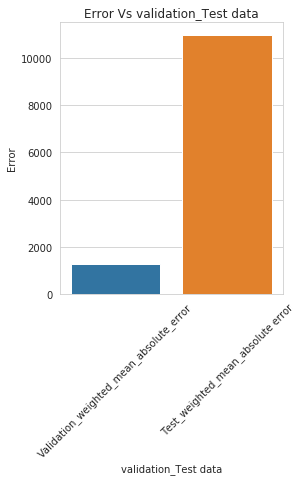

In [135]:
'''Visualizing validation and test weigted mean absolute error  '''

plt.figure(figsize = (4,5))
plt.xticks(rotation=45)
plt.title('Error Vs validation_Test data')
plt.ylabel('Error')
plt.xlabel('validation_Test data')
x_number_list = [ "Validation_weighted_mean_absolute_error", "Test_weighted_mean_absolute error"  ]
y_number_list = [wmae_valid_DNN[0], wmae_test_DNN[0]]
sns.barplot(x = x_number_list,y = y_number_list)

# **Build and Train a XGBOOST model**

In [136]:
# create a regressor object 
XGregr = XGBRegressor(max_depth=10, random_state=1, learning_rate=0.1,n_estimators=10,eval_metric='mae')
XGregr.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:10:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

**Hyperparameter Tuning**

In [137]:
from sklearn.model_selection import GridSearchCV

# parameters for GridSearchCV
param_grid2 = {"n_estimators": [100, 18, 22],
              "max_depth": [10, 15,100],
              "random_state": [1],
              "eval_metric": ['mae'],
              "learning_rate": [0.1]}
grid_search = GridSearchCV(XGregr, param_grid=param_grid2)
grid_search.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:10:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:11:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:11:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:12:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:12:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:13:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:13:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:13:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:13:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:15:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:16:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:18:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:18:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:19:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:19:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:19:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:20:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:40:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:41:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:43:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, eval_metric='mae',
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=10, min_child_weight=1,
                                    missing=None, n_estimators=10, n_jobs=1,
                                    nthread=None, objective='reg:linear',
                                    random_state=1, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'eval_metric': ['mae'], 'learning_rate': [0.1],
                         

In [0]:
grid_search=GridSearchCV(
    XGBRegressor(),
    param_grid2,#Dictionary
    verbose=1,#Controls the verbosity
    cv=3, #cross-validation generator
    n_jobs=-1 #computer uses all of it’s processors to perform the model
)

In [139]:
grid_results=grid_search.fit(X_train,Y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 13.4min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:59:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [140]:
grid_results.best_params_

{'eval_metric': 'mae',
 'learning_rate': 0.1,
 'max_depth': 15,
 'n_estimators': 100,
 'random_state': 1}

In [141]:
XGregr = XGBRegressor(max_depth=15, random_state=1, learning_rate=0.1,n_estimators=100,eval_metric='mae')
XGregr.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
y_pred_XG = XGregr.predict(X_valid)

In [143]:
'''Calculate WMAE for the validation dataset'''
WMAE_valid_XG=weighted_mean_absolute_error(XGregr,X_valid,Y_valid,x_valid.IsHoliday_weight,sum_result_valid.IsHoliday_weight)
WMAE_valid_XG

('weighted_mean_absolute_error', [199.90734777600414])

**Feature importance**

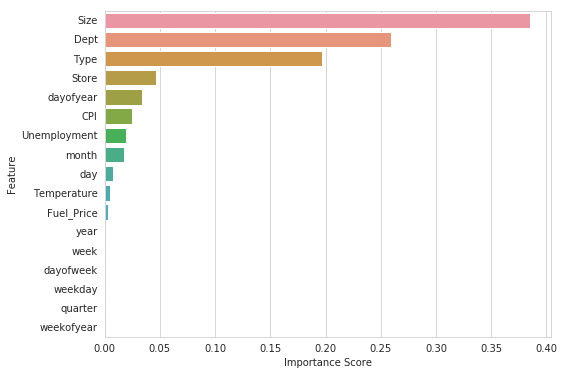

In [144]:
'''Calculate feature importance scores with XGBoost model'''

feat_imps = pd.DataFrame(XGregr.feature_importances_, index = X_train.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")

**Validating on test data**

In [0]:
ytest_pred_XG = XGregr.predict(X_test)

In [146]:
'''Calculate WMAE for the test dataset'''
WMAE_test_XG=weighted_mean_absolute_error(XGregr,X_test,Y_test,x_test.IsHoliday_weight,sum_result_test.IsHoliday_weight)
WMAE_test_XG

('weighted_mean_absolute_error', [2269.9463770141438])

In [0]:
w_test_XG=string_process(WMAE_test_XG[1])

In [0]:
w_valid_XG=string_process(WMAE_valid_XG[1])

In [0]:
wmae_test_XG = string_to_float(w_test_XG)

In [0]:
wmae_valid_XG = string_to_float(w_valid_XG)

In [0]:
model="XGBRegressor"
model_list_wmae.append(model)
wmae_list.append(wmae_test_XG[0])

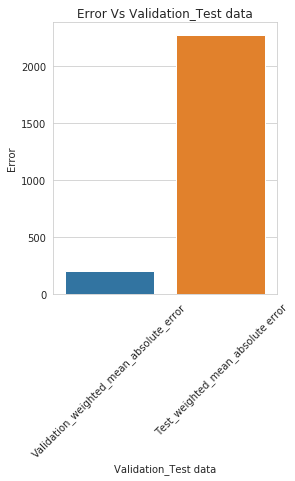

In [152]:
'''Visualizing validation and test weighted mean absolute error '''

plt.figure(figsize = (4,5))
plt.xticks(rotation=45)
plt.title('Error Vs Validation_Test data')
plt.ylabel('Error')
plt.xlabel('Validation_Test data')
x_number_list = [ "Validation_weighted_mean_absolute_error", "Test_weighted_mean_absolute error"  ]
y_number_list = [wmae_valid_XG[0], wmae_test_XG[0]]
sns.barplot(x = x_number_list,y = y_number_list)

# **Build and Train a Random Forest model**

In [153]:
# create a regressor object 
RFregr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=10)
RFregr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

**Hyperparameter Tuning**

In [154]:
from sklearn.model_selection import GridSearchCV

# parameters for GridSearchCV
param_grid2 = {"n_estimators": [100, 18, 22],
              "max_depth": [10, 15,100],
              "random_state": [0]
             }
grid_search = GridSearchCV(RFregr, param_grid=param_grid2)
grid_search.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=10, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [10, 15, 100],
                         'n_estimators': [100, 18, 2

In [0]:
grid_search=GridSearchCV(
    RandomForestRegressor(),
    param_grid2,#Dictionary
    verbose=1,#Controls the verbosity
    cv=3, #cross-validation generator
    n_jobs=-1 #computer uses all of it’s processors to perform the model
)

In [156]:
grid_results=grid_search.fit(X_train,Y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 10.0min finished


In [157]:
grid_results.best_params_

{'max_depth': 100, 'n_estimators': 100, 'random_state': 0}

In [158]:
RFregr = RandomForestRegressor(max_depth=100, random_state=0, n_estimators=100)
RFregr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
y_pred_RF = RFregr.predict(X_valid)

In [160]:
'''Calculate WMAE for the validation dataset'''
WMAE_valid_RF=weighted_mean_absolute_error(RFregr,X_valid,Y_valid,x_valid.IsHoliday_weight,sum_result_valid.IsHoliday_weight)
WMAE_valid_RF

('weighted_mean_absolute_error', [231.96413903116277])

**Feature importance**

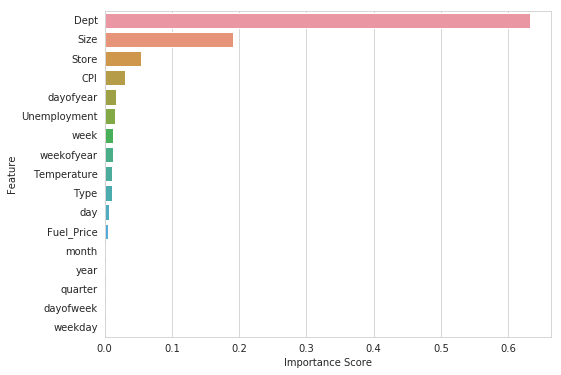

In [161]:
'''Calculate feature importance scores with Random Forest model'''

feat_imps = pd.DataFrame(RFregr.feature_importances_, index = X_train.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")

**Validating on test data**

In [0]:
ytest_pred_RF = RFregr.predict(X_test)

In [163]:
'''Calculate WMAE for the test dataset'''
WMAE_test_RF=weighted_mean_absolute_error(RFregr,X_test,Y_test,x_test.IsHoliday_weight,sum_result_test.IsHoliday_weight)
WMAE_test_RF

('weighted_mean_absolute_error', [2315.8970354624253])

In [0]:
w_test_RF=string_process(WMAE_test_RF[1])

In [0]:
w_valid_RF=string_process(WMAE_valid_RF[1])

In [0]:
wmae_test_RF = string_to_float(w_test_RF)

In [0]:
wmae_valid_RF = string_to_float(w_valid_RF)

In [0]:
model="RandomForestRegressor"
model_list_wmae.append(model)
wmae_list.append(wmae_test_RF[0])

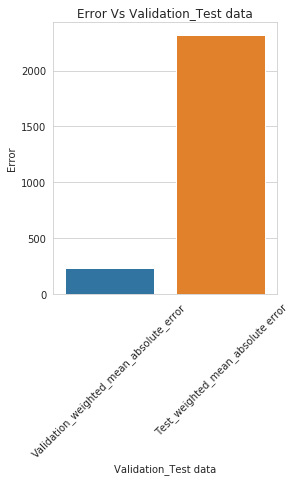

In [169]:
'''Visualizing validation and test weighted mean absolute error '''

plt.figure(figsize = (4,5))
plt.xticks(rotation=45)
plt.title('Error Vs Validation_Test data')
plt.ylabel('Error')
plt.xlabel('Validation_Test data')
x_number_list = ["Validation_weighted_mean_absolute_error", "Test_weighted_mean_absolute error"  ]
y_number_list = [wmae_valid_RF[0], wmae_test_RF[0]]
sns.barplot(x = x_number_list,y = y_number_list)

# **Build and Train a Multivariate Regression model**

In [170]:
# There no difference even if the data is normalized or not
from sklearn.linear_model import LinearRegression
Lregr = LinearRegression(n_jobs=-1,normalize=True)
Lregr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [0]:
y_pred_L = Lregr.predict(X_valid)

In [172]:
'''Calculate WMAE for the validation dataset'''
WMAE_valid_L=weighted_mean_absolute_error(Lregr,X_valid,Y_valid,x_valid.IsHoliday_weight,sum_result_valid.IsHoliday_weight)
WMAE_valid_L

('weighted_mean_absolute_error', [1659.4107795562024])

**Validating on test data**

In [0]:
ytest_pred_L = Lregr.predict(X_test)

In [174]:
'''Calculate WMAE for the test dataset'''
WMAE_test_L=weighted_mean_absolute_error(Lregr,X_test,Y_test,x_test.IsHoliday_weight,sum_result_test.IsHoliday_weight)
WMAE_test_L

('weighted_mean_absolute_error', [14117.052115287535])

In [0]:
w_test_L=string_process(WMAE_test_L[1])

In [0]:
w_valid_L=string_process(WMAE_valid_L[1])

In [0]:
wmae_test_L = string_to_float(w_test_L)

In [0]:
wmae_valid_L = string_to_float(w_valid_L)

In [0]:
model="LinearRegression"
model_list_wmae.append(model)
wmae_list.append(wmae_test_L[0])

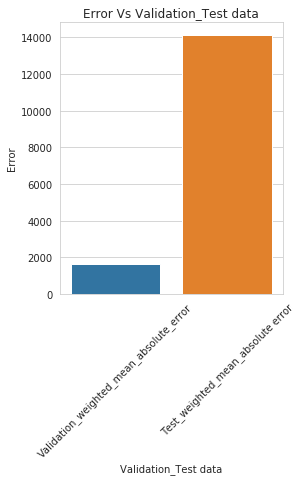

In [180]:
'''Visualizing validation and test weighted mean absolute error '''

plt.figure(figsize = (4,5))
plt.xticks(rotation=45)
plt.title('Error Vs Validation_Test data')
plt.ylabel('Error')
plt.xlabel('Validation_Test data')
x_number_list = ["Validation_weighted_mean_absolute_error", "Test_weighted_mean_absolute error"]
y_number_list = [wmae_valid_L[0], wmae_test_L[0]]
sns.barplot(x = x_number_list,y = y_number_list)
 


# **Build and Train a ExtraTree Regression model**

In [181]:
from sklearn.ensemble import ExtraTreesRegressor
# create a regressor object 
ETregr = ExtraTreesRegressor(max_depth=10, random_state=1, n_estimators=100)
ETregr.fit(X_train, Y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=10,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=1, verbose=0,
                    warm_start=False)

**Hyperparameter Tuning**

In [182]:
from sklearn.model_selection import GridSearchCV

# parameters for GridSearchCV
param_grid2 = {"n_estimators": [100, 18, 22],
              "max_depth": [10, 15,100],
              "random_state": [1]
             }
grid_search = GridSearchCV(ETregr, param_grid=param_grid2)
grid_search.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse',
                                           max_depth=10, max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=1,
                                           verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [10, 15, 100],
                         'n_estimators': [100, 18, 22], 'random_state': 

In [0]:
grid_search=GridSearchCV(
    ExtraTreesRegressor(),
    param_grid2,#Dictionary
    verbose=1,#Controls the verbosity
    cv=3, #cross-validation generator
    n_jobs=-1 #computer uses all of it’s processors to perform the model
)

In [184]:
grid_results=grid_search.fit(X_train,Y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  6.2min finished


In [185]:
grid_results.best_params_

{'max_depth': 100, 'n_estimators': 100, 'random_state': 1}

In [186]:
ETregr = ExtraTreesRegressor(max_depth=100, random_state=1, n_estimators=100)
ETregr.fit(X_train, Y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=100,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=1, verbose=0,
                    warm_start=False)

In [0]:
y_pred_ET = ETregr.predict(X_valid)

In [188]:
'''Calculate WMAE for the validation dataset'''
WMAE_valid_ET=weighted_mean_absolute_error(ETregr,X_valid,Y_valid,x_valid.IsHoliday_weight,sum_result_valid.IsHoliday_weight)
WMAE_valid_ET

('weighted_mean_absolute_error', [195.28406147023153])

**Feature importance**

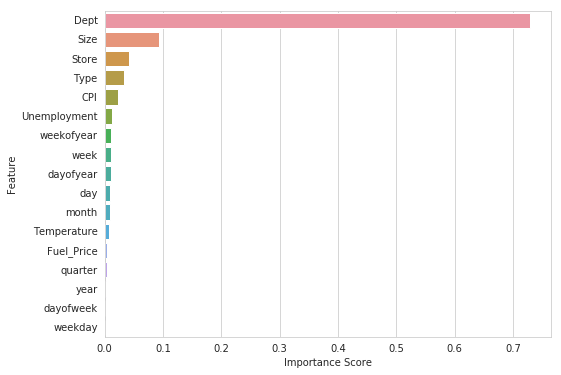

In [189]:
'''Calculate feature importance scores with Extra Trees model'''

feat_imps = pd.DataFrame(ETregr.feature_importances_, index = X_train.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")

**Validating on test data**

In [0]:
ytest_pred_ET = ETregr.predict(X_test)

In [191]:
'''Calculate WMAE for the test dataset'''
WMAE_test_ET=weighted_mean_absolute_error(ETregr,X_test,Y_test,x_test.IsHoliday_weight,sum_result_test.IsHoliday_weight)
WMAE_test_ET

('weighted_mean_absolute_error', [1754.306666604776])

In [0]:
w_test_ET=string_process(WMAE_test_ET[1])

In [0]:
w_valid_ET=string_process(WMAE_valid_ET[1])

In [0]:
wmae_test_ET = string_to_float(w_test_ET)

In [0]:
wmae_valid_ET = string_to_float(w_valid_ET)

In [0]:
model="ExtraTreesRegressor"
model_list_wmae.append(model)
wmae_list.append(wmae_test_ET[0])

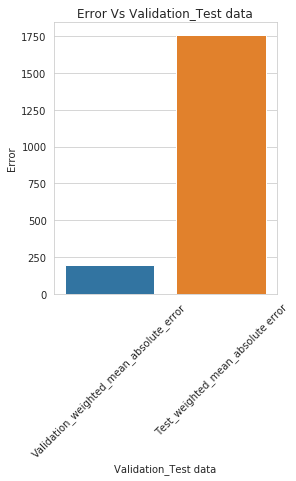

In [197]:
'''Visualizing validation and test weighted mean absolute error '''

plt.figure(figsize = (4,5))
plt.xticks(rotation=45)
plt.title('Error Vs Validation_Test data')
plt.ylabel('Error')
plt.xlabel('Validation_Test data')
x_number_list = [ "Validation_weighted_mean_absolute_error", "Test_weighted_mean_absolute error"  ]
y_number_list = [wmae_valid_ET[0], wmae_test_ET[0]]
sns.barplot(x = x_number_list,y = y_number_list)

# **Exploring the weighted median absolute error achieved by each model**

In [198]:
performance_df =  pd.DataFrame({"Model": model_list_wmae,"weighted Mean absolute error": wmae_list})
performance_df

,Model,weighted Mean absolute error
0,KNeighborsRegressor,7432.055314
1,Deep Neural Network,10959.056110
2,XGBRegressor,2269.946377
3,RandomForestRegressor,2315.897035
4,LinearRegression,14117.052115
5,ExtraTreesRegressor,1754.306667


In [199]:
# Sorting data based on weighted mean absolute error
performance_df.sort_values(by = ["weighted Mean absolute error"],inplace = True)
print(performance_df.head(7))

                   Model  weighted Mean absolute error
5    ExtraTreesRegressor                   1754.306667
2           XGBRegressor                   2269.946377
3  RandomForestRegressor                   2315.897035
0    KNeighborsRegressor                   7432.055314
1    Deep Neural Network                  10959.056110
4       LinearRegression                  14117.052115


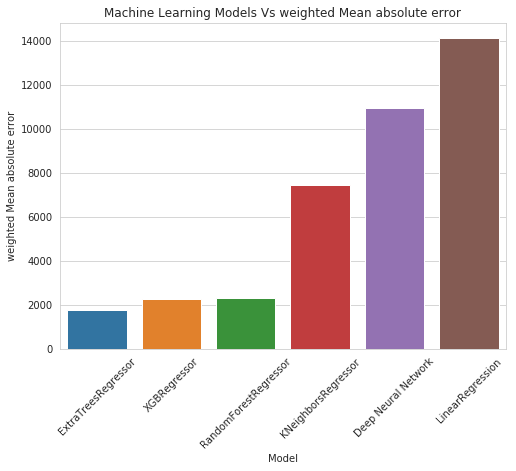

In [200]:
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
plt.title('Machine Learning Models Vs weighted Mean absolute error')
sns.barplot(x = "Model",y ="weighted Mean absolute error",data = performance_df)